# 使用 `braincell` 对 Hodgkin-Huxley 型 E-I 网络进行仿真

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chaobrain/brain-modeling-ecosystem/blob/develop/docs/braincell_HH_EI_network-zh.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/chaobrain/brain-modeling-ecosystem/blob/develop/docs/braincell_HH_EI_network-zh.ipynb)

本节介绍使用 `braincell` 对 Hodgkin-Huxley 型 E-I 网络进行仿真。

在学习使用 `braincell` 对 HH 型的 E - I 网络进行建模之前，你应该已经学会了如何对 HH 型的[离子通道和神经元](braincell_HH_neuron-zh.ipynb)进行建模。

## E-I 网络概述

在上世纪，大量神经生物学实验都发现，即便是在同样的外部刺激重复呈现的条件下，神经元每次产生的脉冲序列都不同，且单次脉冲序列表现出极不规律的统计行为。同时，又有实验发现，如果切断神经元之间的连接，单独对皮层切片施加恒定刺激，则神经元会产生规律发放，这说明完整大脑中神经元的不规律发放应源自于神经网络的内部性质，而不是单神经元特性。

因此，在单神经元的层级之上，我们很有必要对神经元组成的网络进行仿真建模。

研究者们还意识到，一个神经元会接收到成千上万个神经元的输入，假设这些突触前神经元相互独立地无规律发放，则根据中心极限定理，它们相加的总效果并不会有很大波动，这将使得突触后神经元产生有规律发放，这样的推论和上述的实验结果矛盾。为了克服这个矛盾，他们提出网络中应同时存在兴奋性神经元和抑制性神经元，且两种神经元的输入必须是平衡的、相互抵消的，此时神经元接收到输入的均值维持在一个很小的值，波动才足够显著，从而促使神经元无规律发放。

由此，研究者们提出了一个重要的概念：兴奋 - 抑制平衡网络。之后，这一概念被大量实验证明，包括单神经元和脑区间的连接模式等。兴奋 - 抑制平衡网络已经被广泛接受为大脑连接的基本法则。

这种网络的典型结构如下图：

![兴奋-抑制平衡网络结构](_static/image/braincell_HH_EI_network_structure.png)

观察网络结构图，可以发现神经元群之间和神经元群内部都存在突触连接。

- 兴奋 - 兴奋 连接
- 兴奋 - 抑制 连接
- 抑制 - 兴奋 连接
- 抑制 - 抑制 连接

整个网络除了内部连接之外，还会接受外部的电流输入。

## E-I 网络建模

在对 E - I 网络进行建模之前，我们需要有已经完成建模的神经元。

先引入之前在 [使用 `braincell` 对 Hodgkin-Huxley 神经元仿真](braincell_HH_neuron-zh.ipynb)中的 HH 型神经元：

In [1]:
import brainstate
import brainunit as u

import braincell

In [2]:
V_th = -20. * u.mV
area = 20000 * u.um ** 2
area = area.in_unit(u.cm ** 2)
Cm = (1 * u.uF * u.cm ** -2) * area  # Membrane Capacitance [pF]

In [3]:
class HH(braincell.SingleCompartment):
    def __init__(self, in_size):
        super().__init__(in_size, C=Cm, solver='ind_exp_euler')
        self.na = braincell.ion.SodiumFixed(in_size, E=50. * u.mV)
        self.na.add(INa=braincell.channel.INa_TM1991(in_size, g_max=100. * u.mS / u.cm ** 2 * area, V_sh=-63. * u.mV))

        self.k = braincell.ion.PotassiumFixed(in_size, E=-90 * u.mV)
        self.k.add(IK=braincell.channel.IK_TM1991(in_size, g_max=30. * u.mS / u.cm ** 2 * area, V_sh=-63. * u.mV))

        self.IL = braincell.channel.IL(in_size, E=-60. * u.mV, g_max=5. * u.nS / u.cm ** 2 * area)

为减少建模难度，我们将兴奋 - 抑制平衡网络进行简化，在此只保留了对所有神经元的兴奋与抑制连接。

该网络有 3200 个兴奋神经元，800 个抑制神经元，共计 4000 个神经元。

本例中突触是指数衰减型突触，它的核心是一个一阶线性微分方程：

$$
\frac{dg}{dt} = -\frac{g}{\tau} + \text{input}(t)
$$

其中：

- $g$ ：突触电导 (synaptic conductance)
- $\tau$ ：衰减时间常数 (decay time constant)
- $\text{input}(t)$ ：来自前突触的输入脉冲

结合以上信息，对网络进行建模：

In [4]:
class EINet(brainstate.nn.Module):
    def __init__(self):
        super().__init__()
        self.n_exc = 3200
        self.n_inh = 800
        self.num = self.n_exc + self.n_inh
        self.N = HH(self.num)

        self.E = brainstate.nn.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(self.n_exc, self.num, conn_num=0.02, conn_weight=6. * u.nS),
            syn=brainstate.nn.Expon(self.num, tau=5. * u.ms),
            out=brainstate.nn.COBA(E=0. * u.mV),
            post=self.N
        )
        self.I = brainstate.nn.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(self.n_inh, self.num, conn_num=0.02, conn_weight=67. * u.nS),
            syn=brainstate.nn.Expon(self.num, tau=10. * u.ms),
            out=brainstate.nn.COBA(E=-80. * u.mV),
            post=self.N
        )

    def update(self, t):
        with brainstate.environ.context(t=t):
            spk = self.N.spike.value
            self.E(spk[:self.n_exc])
            self.I(spk[self.n_exc:])
            spk = self.N(0. * u.nA)
            return spk

观察以上代码，不难发现对网络建模的重点就是对突触建模。

- `comm` 可以选择不同的连接方式，如 `FixedNumConn`、 `EventFixedProb`
- `syn` 可以选择不同的突触，如 `Expon`、 `DualExpon`、 `Alpha`、`AMPA`、`GABAa`
- `out` 可以选择不同的输出方式，如 `COBA`、 `CUBA`

其中，不同的连接方式、不同的突触，我们只需要对其设定其需要的参数即可。

比如本例中使用的 `EventFixedNumConn` 连接，就需要设定前突触和后突触神经元的数量，连接概率和突触电导。
而 `Expon` 突触，则需要设定前突触神经元的数量，以及突触电导衰减的时间常数。

这些可供选择的组件在我们 `braincell` 框架中已经预设好了，可以根据实际需求任意替换使用。

对其仿真：

In [5]:
# network
net = EINet()
brainstate.nn.init_all_states(net)

EINet(
  n_exc=3200,
  n_inh=800,
  num=4000,
  N=HH(
    in_size=(4000,),
    out_size=(4000,),
    current_inputs={
      'AlignPostProj0': COBA(
        E=0. * mvolt
      ),
      'AlignPostProj1': COBA(
        E=-80. * mvolt
      )
    },
    ion_channels={},
    C=0.0002 * ufarad,
    V_th=0. * mvolt,
    V_initializer=Uniform(
      min_val=-70 * mvolt,
      max_val=-60. * mvolt,
      rng=RandomState([ 294465820 3092832770]),
      unit=Unit(10.0^0)
    ),
    spk_fun=ReluGrad(alpha=0.3, width=1.0),
    solver=<function ind_exp_euler_step at 0x0000026DD24ACB80>,
    na=SodiumFixed(
      size=(4000,),
      name=None,
      channels={
        'INa': INa_TM1991(
          size=(4000,),
          name=None,
          phi=1.0,
          g_max=0.02 * msiemens,
          V_sh=-63. * mvolt,
          p=DiffEqState(
            value=ShapedArray(float32[4000]),
            _derivative=None,
            _diffusion=None
          ),
          q=DiffEqState(
            value=ShapedAr

In [6]:
# simulation
with brainstate.environ.context(dt=0.1 * u.ms):
    times = u.math.arange(0. * u.ms, 100. * u.ms, brainstate.environ.get_dt())
    spikes = brainstate.compile.for_loop(net.update, times, pbar=brainstate.compile.ProgressBar(10))

  0%|          | 0/1000 [00:00<?, ?it/s]

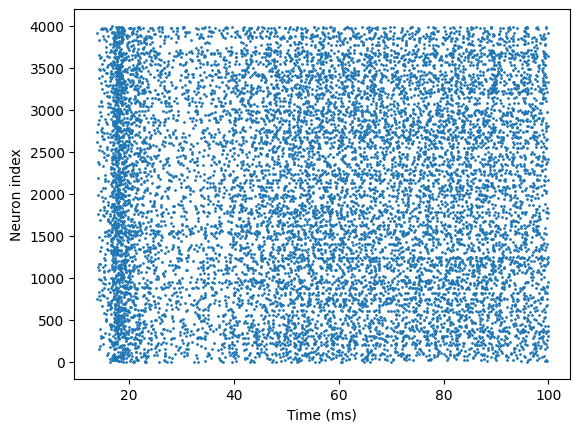

In [7]:
import matplotlib.pyplot as plt

# visualization
t_indices, n_indices = u.math.where(spikes)
plt.scatter(times[t_indices], n_indices, s=1)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.show()

观察运行结果，很明显，我们建立的 HH 型 E - I 神经网络产生了 spike ，拥有丰富的电生理特性。

本文中举例的模型来自：

- Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies., J. Comput. Neurosci., 23, 3, 349–98